In [1]:
import requests
import collections
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import networkx as nx
import warnings
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Анализ взаимосвязей друзей пользователя vk

In [2]:
access_token = '1d1e0bf3e5dadebaf56198814ae43bdf4b27e23771fce1ea25d21a14b3ef93b9e93623245fc64197055d8' # токен для api vk
v = '5.103' # версия api

def get_friends(id_user):
    
    """Функция, которая получает на вход id пользователя vk
    и возвращает датафрейм его взаимосвязанных друзей за исключением самого пользователя"""
    
    friends_url = 'https://api.vk.com/method/friends.get?access_token={access_token}&user_id={id_user}&v={v}&fields=sex'
    json_response = requests.get(friends_url.format(access_token=access_token, id_user=id_user, v=v)).json()
    user_friends = json_normalize(json_response, ['response', 'items'])
    user_friends = user_friends[user_friends['is_closed']== False]
    
    friends=[]
    for i in user_friends.itertuples():
        try:
            response = requests.get(friends_url.format(access_token=access_token, id_user=i.id, v=v))
            json_response = response.json()
            friend = json_normalize(json_response, ['response', 'items'])
            friend['id0'] = i.id
            friend['last_name0'] = i.last_name
            friend['first_name0'] = i.first_name
            friends.append(friend)
        except:
            if response.status_code != 200:
                print(json_response.status_code)
            continue
    friends = pd.concat(friends, axis=0)
    friends = friends[friends['id'].isin(user_friends.id)].reset_index(drop=True)
    return friends

#### Получение друзей пользователя vk, построение и анализ графа

In [3]:
%%time
# Получаем датафрейма друзей
friends1 = get_friends(1007721)

Wall time: 30.3 s


In [4]:
# Датафрейм друзей
friends1.head(10)

,can_access_closed,deactivated,first_name,first_name0,id,id0,is_closed,last_name,last_name0,lists,online,sex,track_code
0,True,NaN,Марина,Дарья,30942,197,False,Кравец,Бондаренко,NaN,0,1,3ce4595epAKGEpnyO0QJ8oM5xZbEge08kDUVFfEFBFxPLZ...
1,True,NaN,Кирилл,Дарья,85725,197,False,Тртилек,Бондаренко,NaN,0,2,f0efd3aakTJeE7cXHemku1bAr-soyM-lpGWq_jF83C0jGm...
2,True,NaN,Галина,Дарья,150736,197,False,Литовец,Бондаренко,NaN,0,1,f5a45fb2elzbC1gBUeuAEHVzHMg0rcpnbBhS3MXemk0AwM...
3,True,NaN,Иван,Дарья,163128,197,False,Порядков,Бондаренко,NaN,0,2,b94eee6c4KFhJvgQm2eYLD2jhHVDdTlSRLANAFxo0nWcZh...
4,True,NaN,Михаил,Дарья,209862,197,False,Кольцов,Бондаренко,NaN,0,2,e1166e78lxeLetgYZ5b59BwJrtd7IOn-L3mwgTq_Z7bJyx...
5,True,NaN,Эльвира,Дарья,267515,197,False,Ширяева,Бондаренко,NaN,0,1,549e077eEM62eTN5T32pV857mF8xoIQMbmLx0LzVhtChI4...
6,True,NaN,Евгений,Дарья,270368,197,False,Пяткин,Бондаренко,NaN,0,2,b64087dcDiRhqcX4N6-CBQCbyZrrjjm40HJp5hRjCKkgcD...
7,True,NaN,Наталья,Дарья,281329,197,False,Петрова,Бондаренко,NaN,0,1,7a18de91-S_E-yCIEas9C7Cw87ZWv_xwDSYrPWIHbg2D2-...
8,True,NaN,Gregory,Дарья,422687,197,False,Yants,Бондаренко,NaN,0,2,ae6bd6c8yJqaentNc_wQ_0xIlFRxMDhEbvJQw-pvfKxPvd...
9,True,NaN,Анна,Дарья,779447,197,False,Ледермюллер,Бондаренко,NaN,0,1,0f860812yB73acQkFNcRnti1dvCbzL-TVriIKX9z-ble8N...


In [5]:
# Собираем граф
G1 = nx.from_pandas_edgelist(friends1, 'id0', 'id')

In [6]:
# Создаем словарь из id и имён друзей
f = {x.id: '{} {}'.format(x.first_name, x.last_name) for x in friends1.itertuples()}
f0 = {x.id0: '{} {}'.format(x.first_name0, x.last_name0) for x in friends1.itertuples()}
f.update(f0)

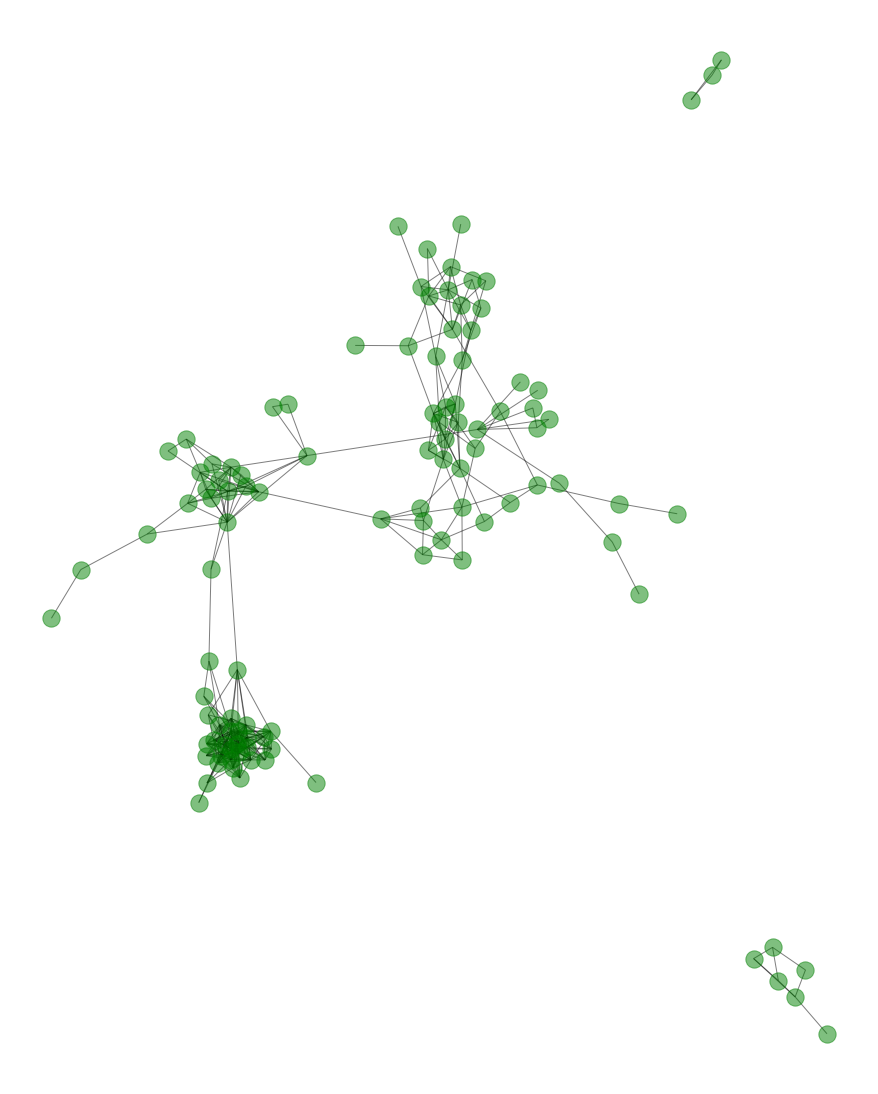

In [7]:
# Общий вид графа
plt.figure(figsize=(12,15))
nx.draw(G1, alpha=0.5, node_color= 'g')

#### Анализ основных метрик графа

##### Betweenness centrality (Степень посредничества):

In [8]:
# Получаем вершины с наибольшей степенью посредничества
betweenness_centrality1 = nx.betweenness_centrality(G1)
betweenness_centrality_counts1 = Counter(betweenness_centrality1)
betweenness_centrality_counts10 = dict(betweenness_centrality_counts1.most_common(10))
for i in betweenness_centrality_counts10:
    print('{} - {} - {}'.format(i, f[i], round(betweenness_centrality_counts10[i],4)))

720162 - Александр Фёдоров - 0.4128
22655859 - Надежда Добрецова - 0.41
7245361 - Konstantin Luzyanin - 0.406
172632218 - Александр Нтифо-Сиао - 0.3287
1327460 - Владимир Михайлов - 0.2121
388847 - Наташенька Бубис - 0.1694
63001883 - Мария Ефремова - 0.1483
1084200 - Сергей Шавкун - 0.1289
270368 - Евгений Пяткин - 0.0809
8828008 - Светлана Каткова - 0.0761


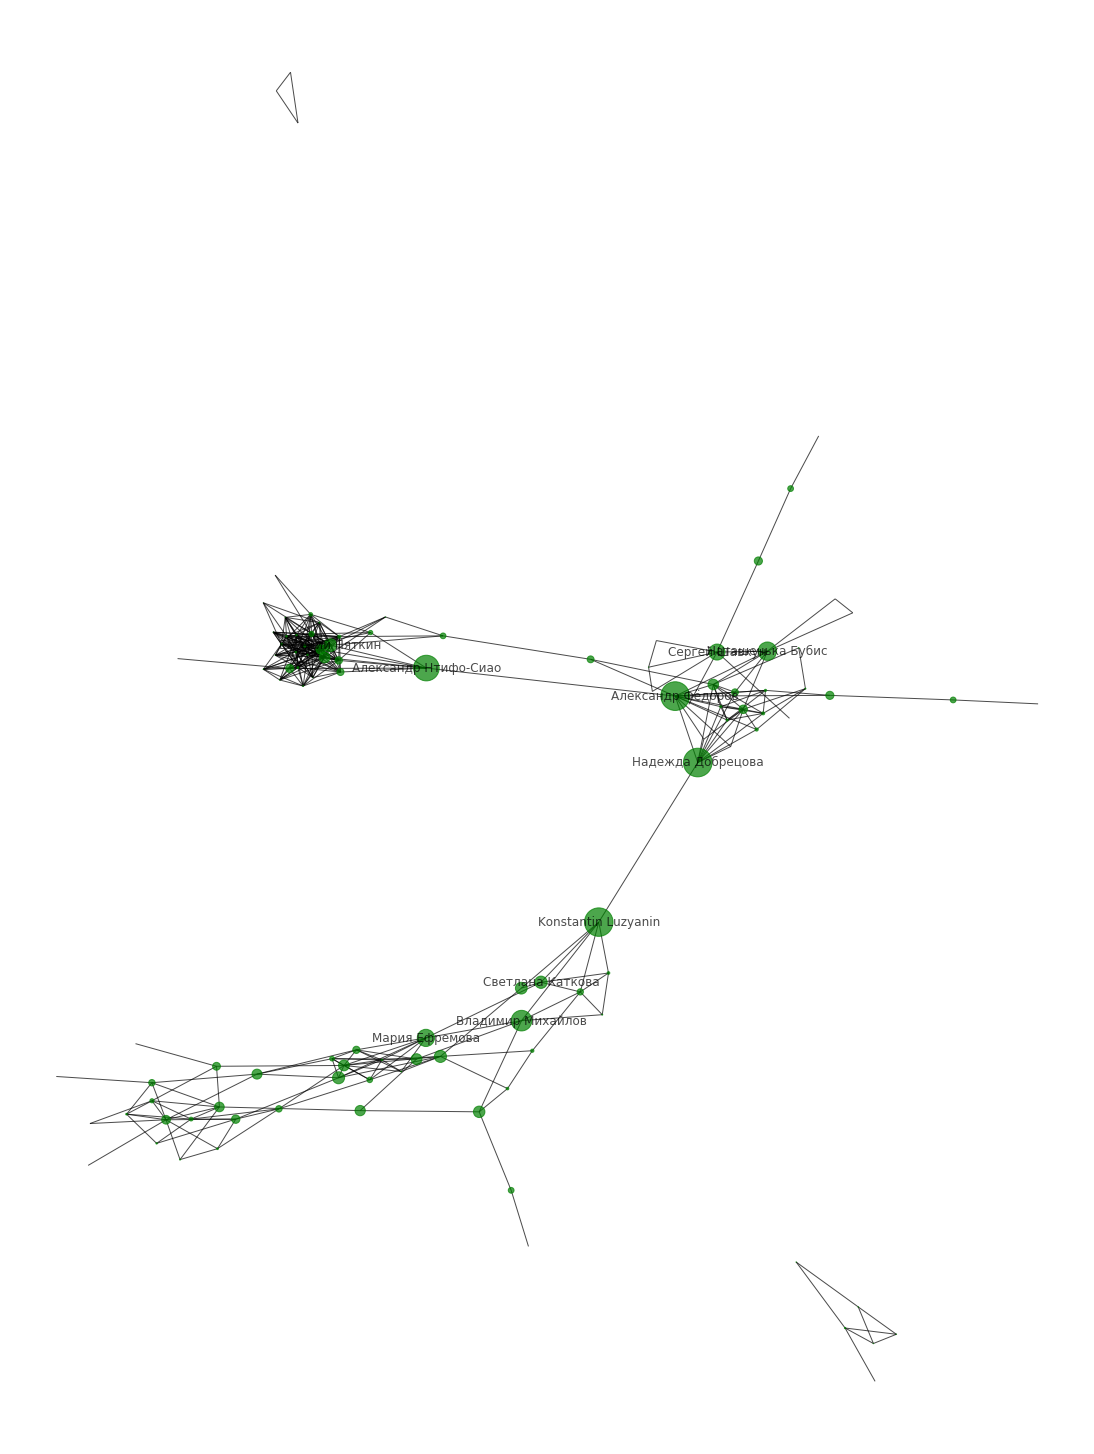

In [24]:
# Выделим наиболее важные вершины на графике
plt.figure(figsize=(15,20))
nx.draw(G1, labels = {i: f[i] for i in betweenness_centrality_counts10},
            node_size=np.array(list(betweenness_centrality1.values())) * 2000,
            alpha=0.7,
            node_color= 'g')

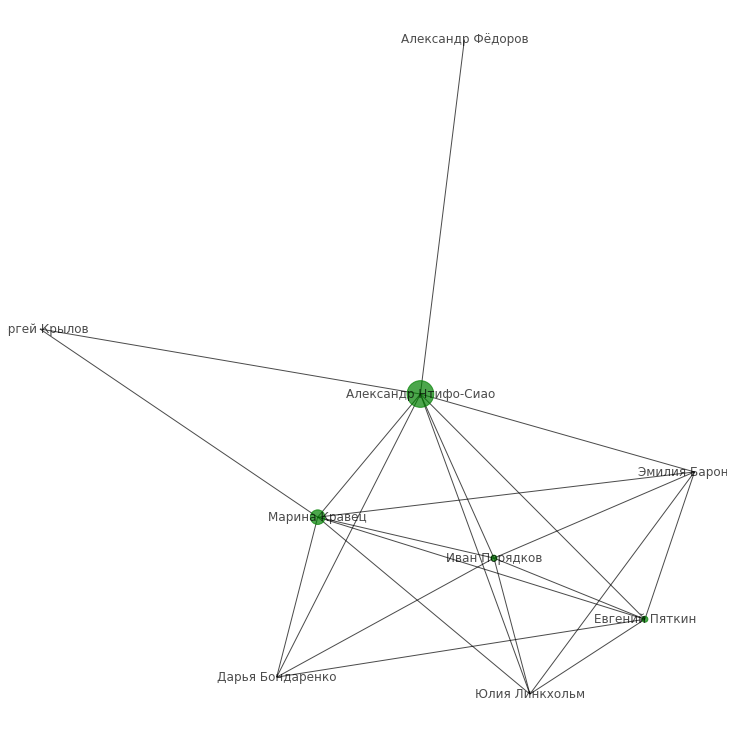

In [10]:
# Возьмём подграф у пользователя 172632218 - Александр Нтифо-Сиао до первого ближайшего соседа, 
# и посмотрим его, т.к. на предыдущей картинке не очень разборчивый "клубок" рядом с ним
sub_G1 = G1.subgraph(nx.single_source_dijkstra_path_length(G1,172632218, 1))

betweenness_centrality1_sub = nx.betweenness_centrality(sub_G1)
betweenness_centrality_counts1_sub = Counter(betweenness_centrality1_sub)
betweenness_centrality_counts10_sub = dict(betweenness_centrality_counts1_sub.most_common(10))

plt.figure(figsize=(10,10))
nx.draw(sub_G1, labels = {i: f[i] for i in betweenness_centrality_counts10_sub},
            node_size=np.array(list(betweenness_centrality1_sub.values())) * 2000,
            alpha=0.7,
            node_color= 'g')

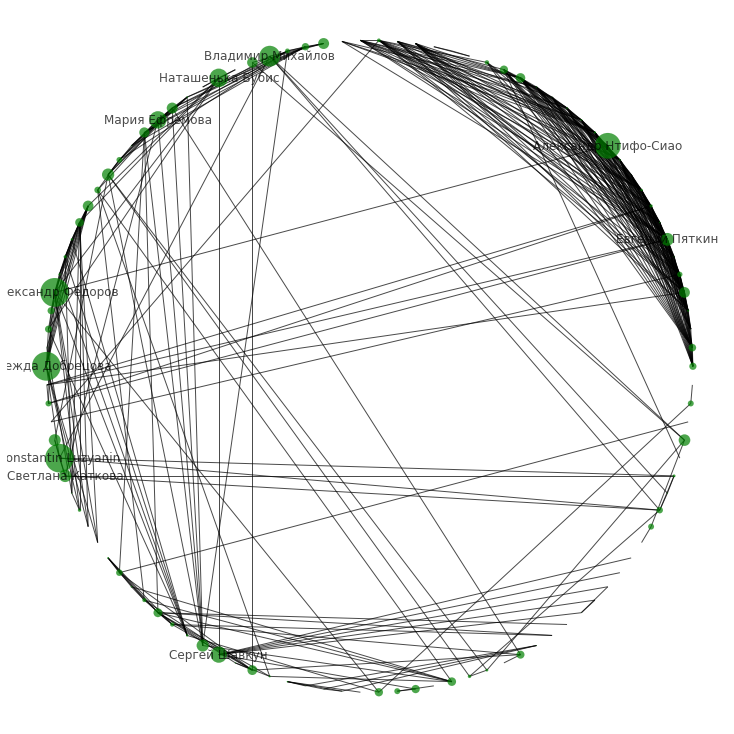

In [11]:
# Круговой вид графа
plt.figure(figsize=(10,10))
nx.draw_shell(
    G1, 
    with_labels=True, 
    alpha=0.7, 
    labels = {i: f[i] for i in betweenness_centrality_counts10},
    linewidths=0.1,
    node_size=np.array(list(betweenness_centrality1.values())) * 2000,
    node_color= 'g',
)

##### Degree centrality

In [12]:
# Посмотрим пользователей, у которых больше всего связей
degree_centrality1 = nx.degree_centrality(G1)
degree_centrality_counts1 = Counter(degree_centrality1)
degree_centrality_counts10 = dict(degree_centrality_counts1.most_common(10))
for i in degree_centrality_counts10:
    print('{} - {} - {}'.format(i, f[i], round(degree_centrality_counts10[i],4)))

270368 - Евгений Пяткин - 0.2385
163128 - Иван Порядков - 0.2202
209862 - Михаил Кольцов - 0.1927
16678831 - Александр Летенков - 0.1835
779447 - Анна Ледермюллер - 0.1743
60153 - Олег Бей-Биенко - 0.1743
3819704 - Юлия Линкхольм - 0.1743
150736 - Галина Литовец - 0.1651
281329 - Наталья Петрова - 0.1651
30942 - Марина Кравец - 0.156


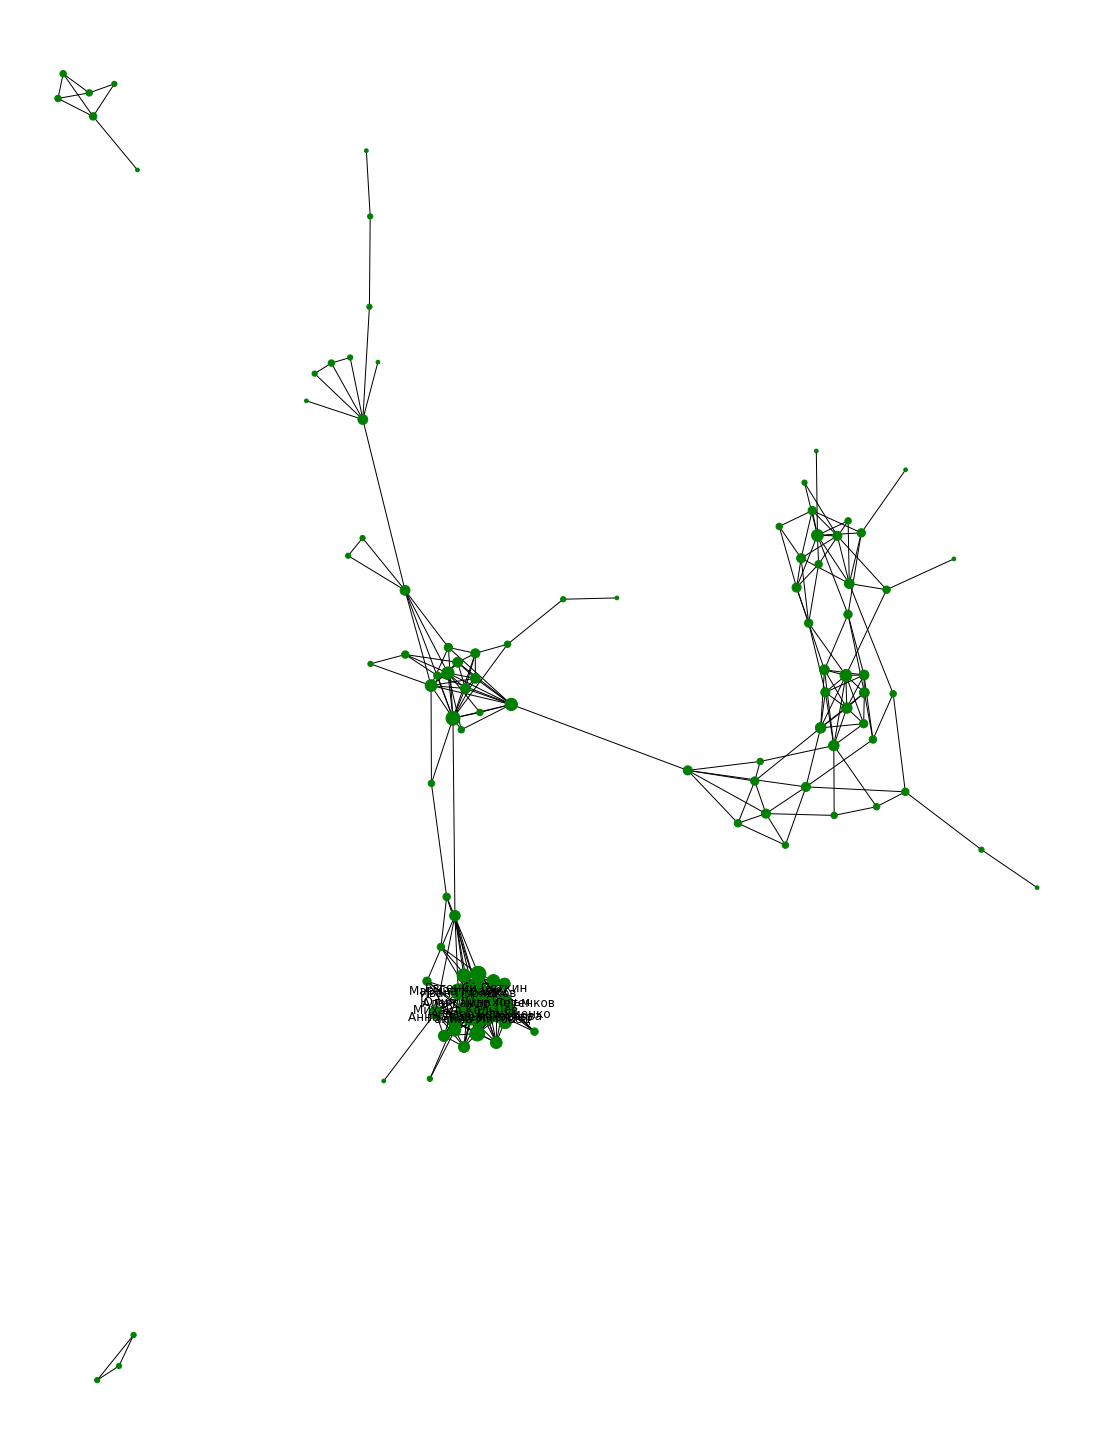

In [13]:
# Эта метрика распределилась более равномерно
plt.figure(figsize=(15,20))
nx.draw(G1, labels = {i: f[i] for i in degree_centrality_counts10},
            node_size=np.array(list(degree_centrality_counts1.values())) * 1500,
            node_color= 'g')

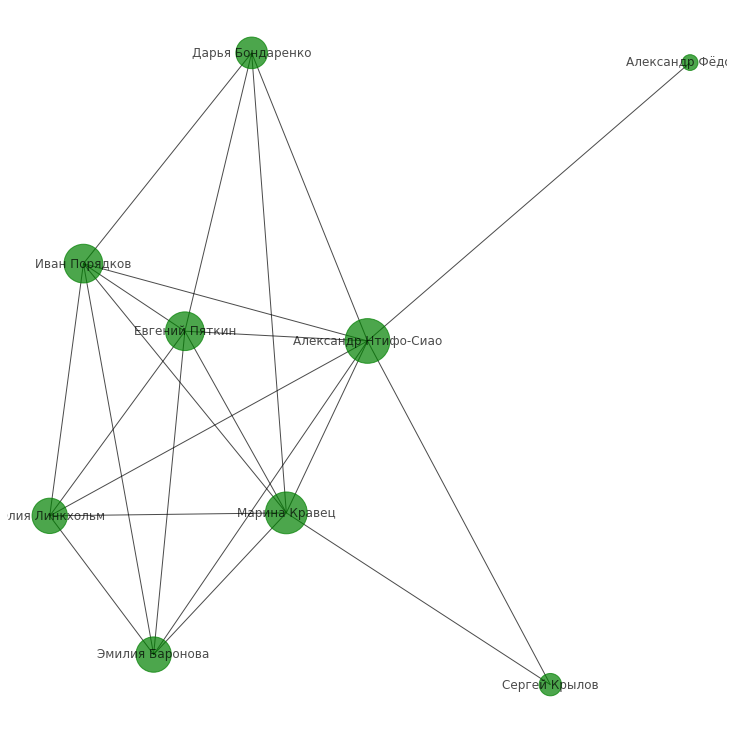

In [14]:
# Посмотрим на подграф пользователя 172632218 - Александр Нтифо-Сиао
degree_centrality1_sub = nx.degree_centrality(sub_G1)
degree_centrality_counts1_sub = Counter(degree_centrality1_sub)
degree_centrality_counts10_sub = dict(degree_centrality_counts1_sub.most_common(10))


plt.figure(figsize=(10,10))
nx.draw(sub_G1, labels = {i: f[i] for i in degree_centrality_counts10_sub},
            node_size=np.array(list(degree_centrality1_sub.values())) * 2000,
            alpha=0.7,
            node_color= 'g')

##### Closeness centrality (Степень близости)

In [15]:
# Посмотрим на узлы более близкие к центру графа
closeness_centrality1 = nx.closeness_centrality(G1)
closeness_centrality_counts1 = Counter(closeness_centrality1)
closeness_centrality_counts10 = dict(closeness_centrality_counts1.most_common(10))
for i in closeness_centrality_counts10:
    print('{} - {} - {}'.format(i, f[i], round(closeness_centrality_counts10[i],4)))

720162 - Александр Фёдоров - 0.2577
22655859 - Надежда Добрецова - 0.2527
7245361 - Konstantin Luzyanin - 0.2389
146724 - Виталий Ломач - 0.2358
285365 - Елена Яковлева - 0.2346
172632218 - Александр Нтифо-Сиао - 0.2317
1760571 - Олеся Дмитрук - 0.2305
314995 - Алексей Кузнецов - 0.226
519481 - Александр Калугин - 0.226
30910821 - Роман Чавычалов - 0.2243


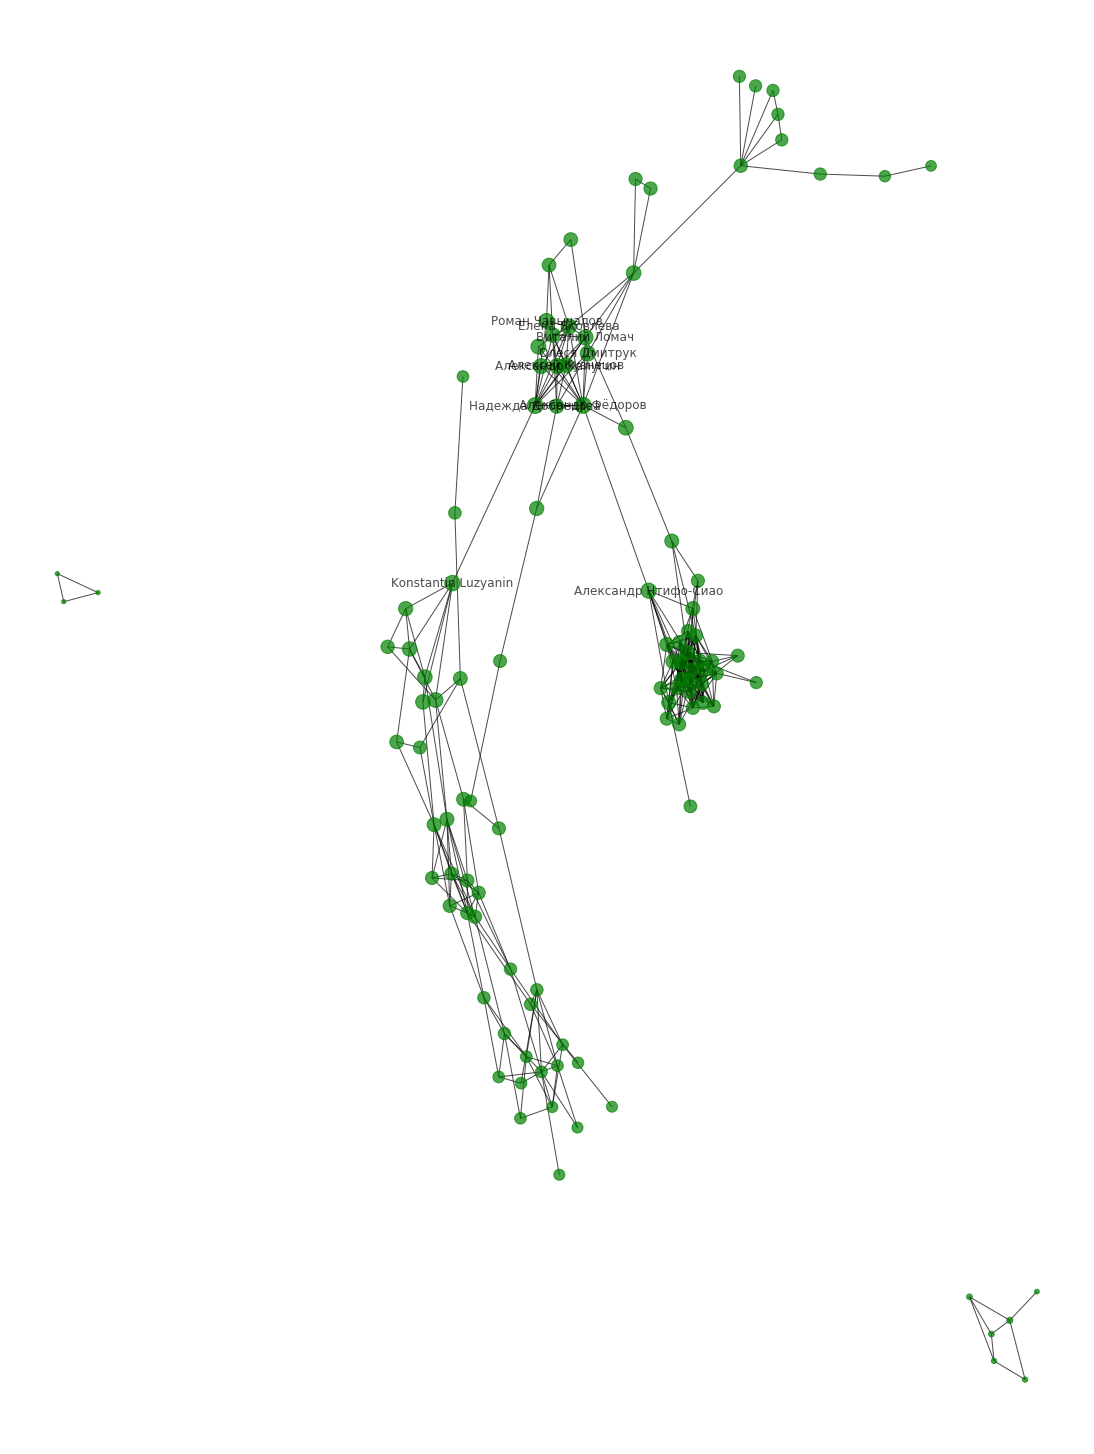

In [25]:
plt.figure(figsize=(15,20))
nx.draw(G1, labels = {i: f[i] for i in closeness_centrality_counts10},
            node_size=np.array(list(closeness_centrality_counts1.values())) * 1000,
            alpha=0.7,
            node_color= 'g')

##### Клики в графе

In [17]:
# Посмотрим на клики в графе
for cliques in nx.find_cliques(G1):
    print([f[i] for i in cliques])

['Наталья Свинцицкая', 'Андрей Палкин']
['Наталья Свинцицкая', 'Елена Эрхитуева', 'Мария Ефремова', 'Владимир Храмчихин']
['Наталья Свинцицкая', 'Елена Эрхитуева', 'Мария Ефремова', 'Екатерина Попова', 'Daria Terran']
['Наталья Свинцицкая', 'Елена Эрхитуева', 'Мария Ефремова', 'Владимир Буков']
['Наталья Свинцицкая', 'Елена Эрхитуева', 'Фёдор Тепляков', 'Владимир Храмчихин']
['Наталья Свинцицкая', 'Елена Эрхитуева', 'Фёдор Тепляков', 'Екатерина Попова']
['Наталья Свинцицкая', 'Елена Эрхитуева', 'Фёдор Тепляков', 'Владимир Буков']
['Наталья Свинцицкая', 'Елена Эрхитуева', 'Георгий Якобсон', 'Владимир Храмчихин']
['Наталья Свинцицкая', 'Елена Эрхитуева', 'Георгий Якобсон', 'Владимир Буков']
['Наталья Свинцицкая', 'Елена Эрхитуева', 'Георгий Якобсон', 'Daria Terran']
['Наталья Свинцицкая', 'Андрей Храмчихин', 'Владимир Храмчихин']
['Любовь Ермилова', 'Глеб Климов']
['Любовь Ермилова', 'Любовь Ермилова (Яковлева)']
['Анна Темнякова', 'Юлия Семенюк', 'Алексей Морозов']
['Дима Костенко', 'Ви

{27414529: Text(-0.2603550181103297, -0.4040723150143198, 'Наталья Свинцицкая'),
 19404125: Text(-0.29606868763159255, -0.36741995748013945, 'Елена Эрхитуева'),
 63001883: Text(-0.29462311285777176, -0.3093456112799543, 'Мария Ефремова'),
 107489: Text(-0.2575562984032085, -0.3600250094690771, 'Екатерина Попова'),
 256183895: Text(-0.3300224927582441, -0.37389884020987874, 'Daria Terran')}

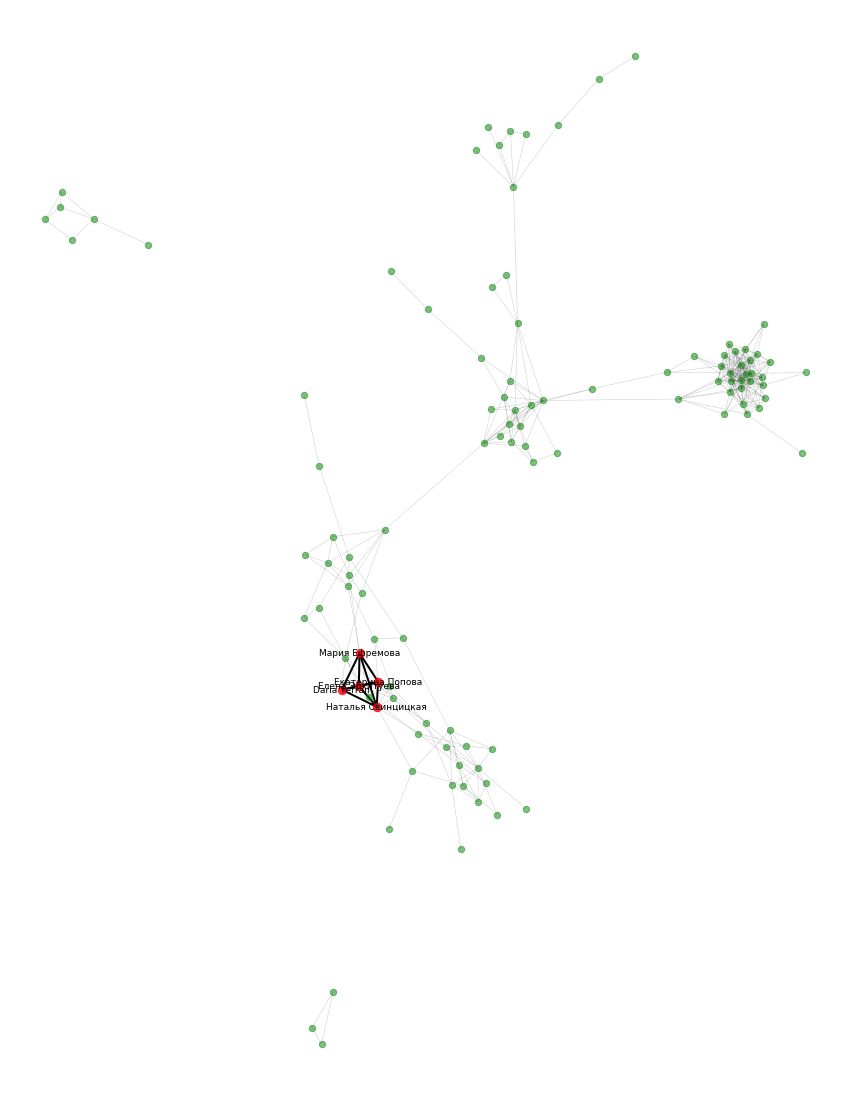

In [27]:
# Отсортируем и посмотрим на какой-нибудь клик на общем графе
cl = sorted(nx.find_cliques(G1), key=lambda x: len(x))[95]

pos=nx.spring_layout(G1)
plt.figure(figsize=(15,20)) 
plt.axis('off')
nx.draw_networkx_nodes(G1,pos,
                       nodelist=cl,
                       node_color='r',
                       node_size=70,
                   alpha=0.8)
nx.draw_networkx_nodes(G1,pos,
                       nodelist=G1.nodes-cl,
                       node_color='g',
                       node_size=40,
                   alpha=0.5)
nx.draw_networkx_edges(G1,pos,width=0.5,alpha=0.2)
nx.draw_networkx_edges(G1,pos,width=2,alpha=1, edgelist=list(combinations(cl,2)))
nx.draw_networkx_labels(G1, pos, labels={i: f[i] for i in cl}, font_size=9)

#### Для интереса посмотрим на граф друзей другого пользователя vk

In [19]:
%%time
friends2 = get_friends(1159288)

Wall time: 25.5 s


In [20]:
G2 = nx.from_pandas_edgelist(friends2, 'id0', 'id')
t = {x.id: '{} {}'.format(x.first_name, x.last_name) for x in friends2.itertuples()}
t0 = {x.id0: '{} {}'.format(x.first_name0, x.last_name0) for x in friends2.itertuples()}
t.update(t0)

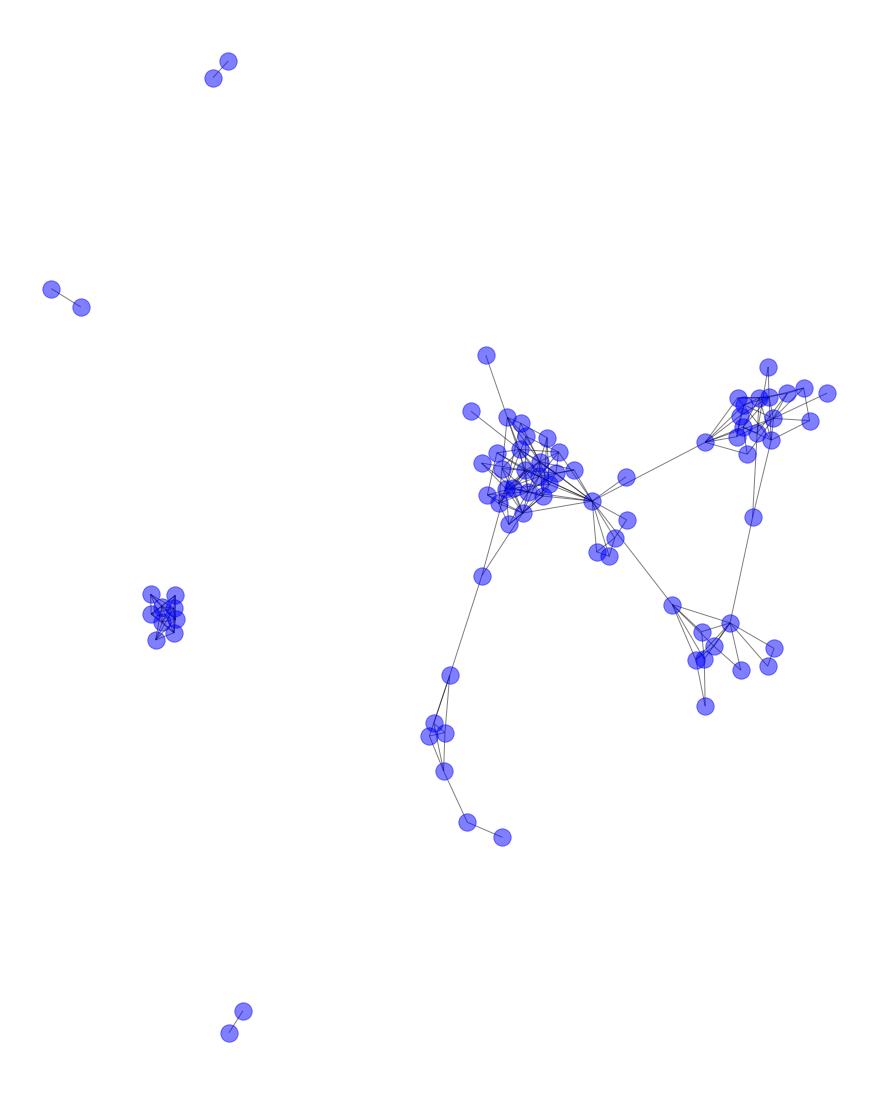

In [21]:
# Общий вид графа
plt.figure(figsize=(12,15))
nx.draw(G2, alpha=0.5, node_color= 'b')

In [22]:
# Для примера посмотрим на степень посредничества 
betweenness_centrality2 = nx.betweenness_centrality(G2)
betweenness_centrality_counts2 = Counter(betweenness_centrality2)
betweenness_centrality_counts20 = dict(betweenness_centrality_counts2.most_common(10))
for i in betweenness_centrality_counts20:
    print('{} - {} - {}'.format(i, t[i], round(betweenness_centrality_counts20[i],4)))

417425 - Арсений Банковский - 0.4027
9122433 - Анастасия Тимофеева - 0.2103
1285213 - Алексей Поляков - 0.135
825726 - Елена Еремина - 0.1326
2827233 - Людмила Волкова - 0.1275
9122140 - Юлия Величко - 0.1112
4708911 - Никита Счастливый - 0.083
70885844 - Анастасия Сенькина - 0.0741
213877 - Андрей Бедов - 0.0534
43645334 - Екатерина Онищенко - 0.0526


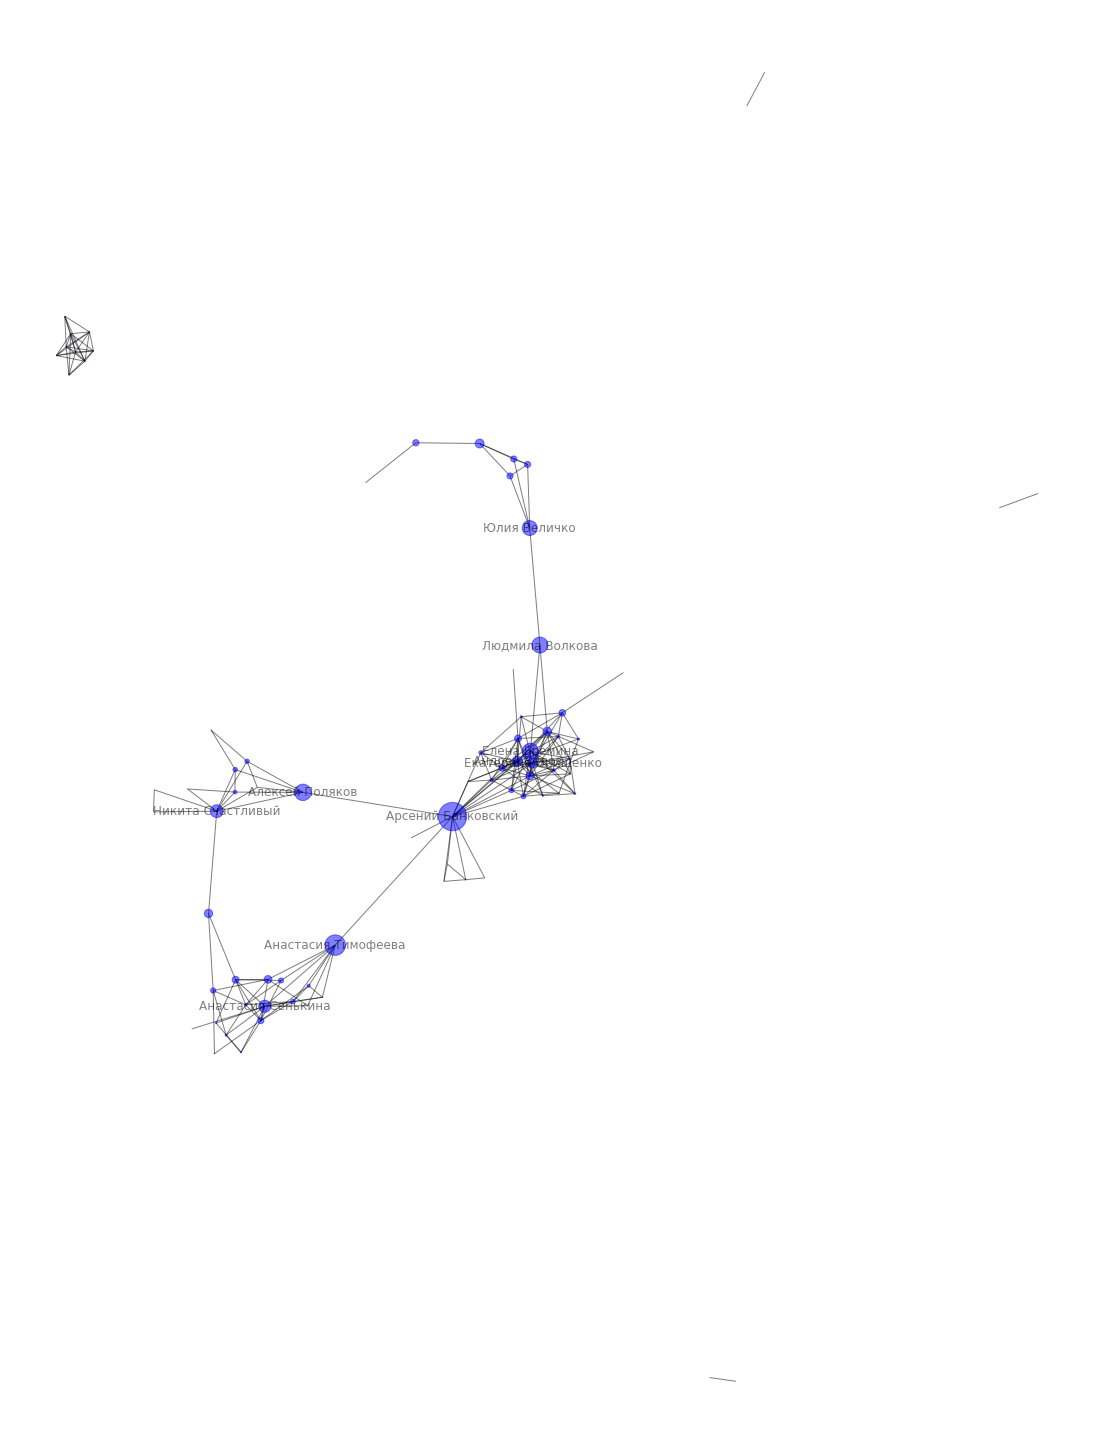

In [28]:
# Отобразим самых главных друзей на графе
plt.figure(figsize=(15,20))
nx.draw(G2, labels = {i: t[i] for i in betweenness_centrality_counts20},
            node_size=np.array(list(betweenness_centrality2.values())) * 2000,
            alpha=0.5,
            node_color= 'b')

#### Вывод:
- Друзья отдельно взятого пользователя достаточно тесно дружат между собой и при этом явно скапливаются в отдельные группы;
- Наиболее интересно у друзей смотреть, наверное, метрику степени посредничества (betweenness centrality), поскольку можно понять кто из друзей более всех связывает группы пользователей.